In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np
import torch
import torchvision
import opendatasets as opd
import pandas as pd
import zipfile
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
from tqdm.notebook import tqdm_notebook
import time

**Download dataset from Kaggle**

In [ ]:
opd.download('https://www.kaggle.com/competitions/dogs-vs-cats/data')

In [ ]:
train_zip = zipfile.ZipFile('/content/dogs-vs-cats/train.zip')
train_zip.extractall('/content/dogs-vs-cats')
train_zip.close()

In [ ]:
train_dir = '/content/dogs-vs-cats/train'
train_file = os.listdir(train_dir)

In [ ]:
img_dirs = []
targets = []
img_h = []
img_w = []
img_c = []
for file_ in tqdm_notebook(train_file,desc='Loading image'):
  time.sleep(0)
  img_dirs.append(train_dir+'/'+file_)
  img_= image.imread(train_dir+'/'+file_)
  img_h.append(img_.shape[0])
  img_w.append(img_.shape[1])
  img_c.append(img_.shape[2])
  target = file_.split('.')[0]
  if target == 'dog':
    targets.append(0) #dog 0
  else:
    targets.append(1) #cat 1
df = pd.DataFrame({'image_dir':img_dirs,'Height':img_h,'Weight':img_w,'chanel':img_c,'image':train_file,'target':targets})
df.tail()

In [ ]:
df['Height'].min(),df['Height'].max()

In [ ]:
df['Weight'].min(),df['Weight'].max()

In [ ]:
img_index = 2
img = image.imread(df['image_dir'][img_index])
label = df['image'][img_index].split('.')[0]
plt.imshow(img)
plt.title(label)
plt.show()

In [ ]:
# Split training data to train set and validation set
def train_val_split(df):
  df = df.sample(frac=1,random_state=999).reset_index(drop=True)
  X = df[['image_dir','image']]
  y = df['target']
  m = len(X)
  m_train = int(0.8*m)
  train_df = df.iloc[:m_train]
  val_df = df.iloc[m_train:]
  return train_df,val_df
train_df,val_df = train_val_split(df)
train_df.head()

In [ ]:
img1 = image.imread(df['image_dir'][2])
img.shape

In [ ]:
type(img1)

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                            torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.ToTensor()])
img1 = transform(img1)
type(img1)

In [ ]:
# Define the transform
transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                            torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.ToTensor()])

# Convert list of image into Pytorch Tensor
class imgdataset():
  def __init__(self,df, transform=None):
    self.df = df
    self.img_dirs = df['image_dir'].values
    self.labels = df['target'].values
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    img = image.imread(self.img_dirs[index])
    img_tensor = self.transform(img)
    label = self.labels[index]
    return img_tensor, label

In [ ]:
train_data = imgdataset(train_df,transform)
val_data = imgdataset(val_df,transform)

In [ ]:
# Create data loaders
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=batch_size,shuffle=False,num_workers=0)

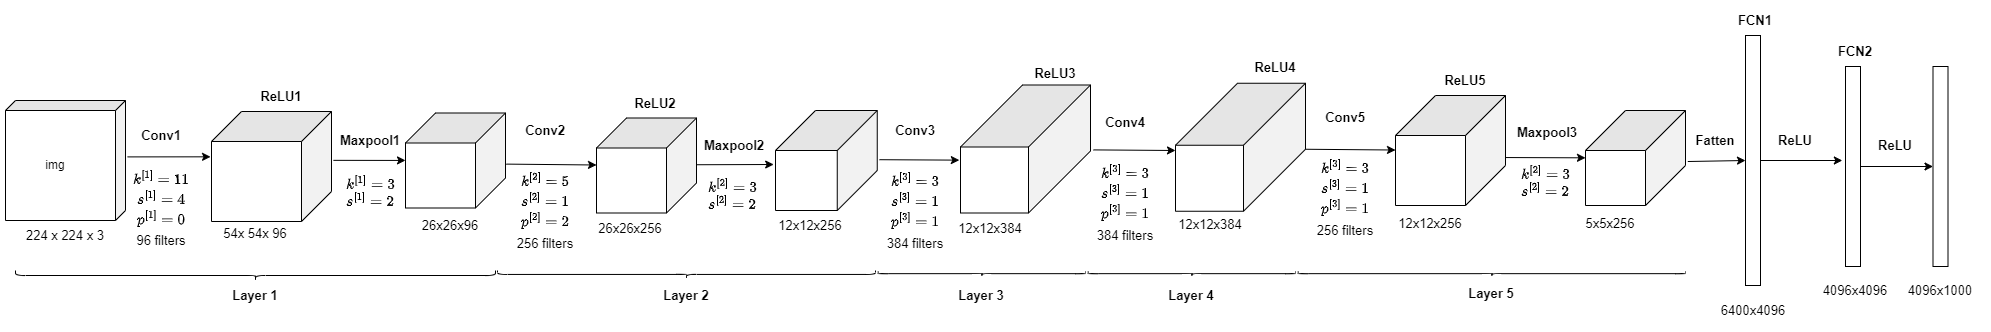

In [ ]:
# Create CNN model
class CNN_Model1(torch.nn.Module):
  def __init__(self):
    super().__init__()
    #Layer 1
    self.conv1 = torch.nn.Conv2d(3,96, kernel_size=11, stride=4, padding=0)
    self.relu1 = torch.nn.ReLU()
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
    #Layer 2
    self.conv2 = torch.nn.Conv2d(96,256, kernel_size=5, padding=2)
    self.relu2 = torch.nn.ReLU()
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
   #Layer 3
    self.conv3 = torch.nn.Conv2d(256,384, kernel_size=3, padding=1)
    self.relu3 = torch.nn.ReLU()
    #Layer 4
    self.conv4 = torch.nn.Conv2d(384,384, kernel_size=3, padding=1)
    self.relu4 = torch.nn.ReLU()
    #Layer 5
    self.conv5 = torch.nn.Conv2d(384,256, kernel_size=3, padding=1)
    self.relu5 = torch.nn.ReLU()
    self.maxpool5 = torch.nn.MaxPool2d(kernel_size=3, stride=2) #5x5x256
    #Fully connected network
    self.fc1 = torch.nn.Linear(6400,4096)
    self.fc2 = torch.nn.Linear(4096,4096)
    self.fc3 = torch.nn.Linear(4096,2)

  def forward(self,x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
    x = self.conv3(x)
    x = self.relu3(x)
    x = self.conv4(x)
    x = self.relu4(x)
    x = self.conv5(x)
    x = self.relu5(x)
    x = self.maxpool5(x)
    x = x.view(-1,6400)
    x = self.fc1(x)
    x = torch.nn.functional.relu(x)
    x = self.fc2(x)
    x = torch.nn.functional.relu(x)
    x = self.fc3(x)
    return x

alex_net=CNN_Model1()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alex_net.parameters(),lr = 0.01,momentum=0.95)
# Use GPU
if torch.cuda.is_available:
    alex_net = alex_net.cuda()

In [ ]:
# Training loop
epochs = 30

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in tqdm_notebook(range(epochs),desc='Progress Bar'):
  time.sleep(0)
  alex_net.train()
  epoch_loss = 0
  iter = 0
  correct = 0
  #Training set
  for i,(input,target) in enumerate(train_loader):
    # Use GPU
    if torch.cuda.is_available():
      input = input.cuda()
      target = target.cuda() 

    optimizer.zero_grad()
    output = alex_net(input)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()
    # Record loss
    epoch_loss += loss.item()
    iter += 1
    # Rerord Accuracy
    _,predict = torch.max(output.data,1)
    correct += (predict == target.data).sum()
  #Training loss
  train_loss.append(epoch_loss/iter)
  #Training Accuracy
  train_acc.append(correct*100/len(train_loader.dataset))

  #Validation set
  alex_net.eval()
  epoch_loss = 0
  iter = 0
  correct = 0
  for i,(input,target) in enumerate(val_loader):
    # Use GPU
    if torch.cuda.is_available():
      input = input.cuda()
      target = target.cuda()

    output = alex_net(input)
    loss = criterion(output, target)
    # Record loss
    epoch_loss += loss.item()
    iter += 1
    # Record accuracy
    _,predict = torch.max(output.data,1)
    correct += (predict == target.data).sum()
  #Validation loss
  val_loss.append(epoch_loss/iter)
  #Validation accuracy
  val_acc.append(correct*100/len(val_loader.dataset))

# Print Loss and Accuracy
print('Epoch %d/%d: Train Loss: %.4f - Train Accuracy: %.4f - Validation Loss: %.4f - Validation Accuracy: %.4f'%(epoch+1,epochs,train_loss[-1],train_acc[-1],val_loss[-1],val_acc[-1]))

# Save the trained model’s learned parameters 
torch.save(alex_net.state_dict(),'/alex_net-weight.pt')

In [ ]:
# Plot Loss and Accuracy
matplotlib.rcParams['figure.figsize'] = [26,8]
fig,(ax1,ax2) = plt.subplots(1,2)

# Loss
ax1.set_title('Loss')
ax1.plot(train_loss,label='Training loss')
ax1.plot(val_loss,label='Validation loss')
ax1.legend()

# Accuracy
ax2.set_title('Accuracy')
ax2.plot([x.cpu() for x in train_acc],label='Training Accuracy')
ax2.plot([x.cpu() for x in val_acc],label='Validation Accuracy')
ax2.legend()

plt.show()

In [ ]:
# Make a predict
img_index = 230
img = image.imread(df['image_dir'][img_index])
label = df['image'][img_index].split('.')[0]
plt.imshow(img)
plt.title(label)
plt.show()

img = transform(img)
img = img.cuda()

output = alex_net(img)
_,r = torch.max(output.data,1)
predict = np.where(r.item()== 0,'dog','cat')
print('Model predict:',predict.item())